<h3>Unsupervised Learning: Mall Customers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv("Mall_Customers.csv")
raw_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Customer ID not relevant here:
data = raw_data.drop("CustomerID",axis=1)

<h4>Cleaning and EDA

In [4]:
# Data types:
data.info()
# All the columns are integers.
# Relatively simple dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [5]:
# Null values:
data.isnull().sum()
# No null values

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
data.describe(include='all')

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200,200.000000,200.000000,200.000000
unique,2,NaN,NaN,NaN
top,Female,NaN,NaN,NaN
freq,112,NaN,NaN,NaN
mean,NaN,38.850000,60.560000,50.200000
std,NaN,13.969007,26.264721,25.823522
min,NaN,18.000000,15.000000,1.000000
25%,NaN,28.750000,41.500000,34.750000
50%,NaN,36.000000,61.500000,50.000000
75%,NaN,49.000000,78.000000,73.000000


In [7]:
# Checking for duplicates:
unique_rows = data.drop_duplicates().shape[0]
duplicate_rows = len(data) - unique_rows

print(f"Total rows: {len(data)}")
print(f"Unique rows: {unique_rows}")
print(f"'Duplicate' rows: {duplicate_rows}")

Total rows: 200
Unique rows: 200
'Duplicate' rows: 0


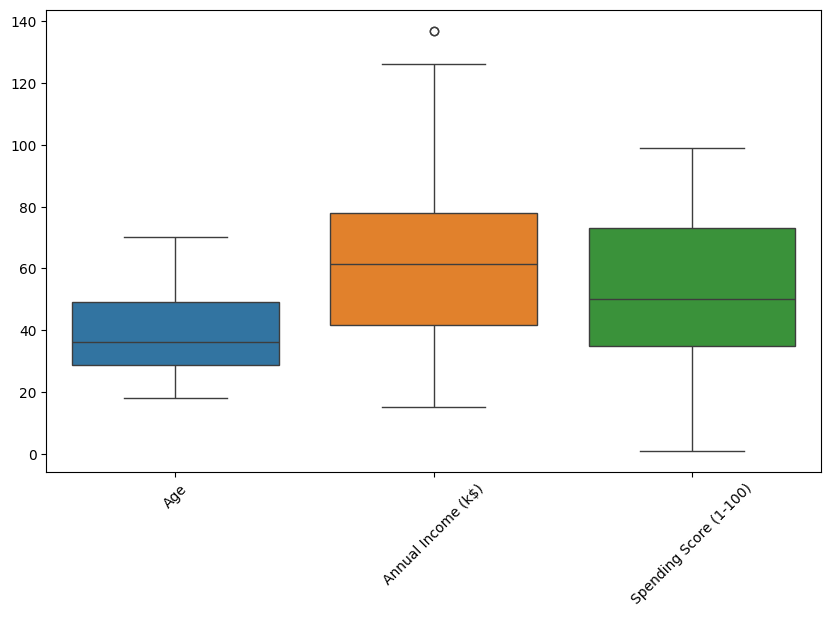

In [8]:
# Checking data distribution and outliers:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]])
plt.xticks(rotation=45)
plt.show()

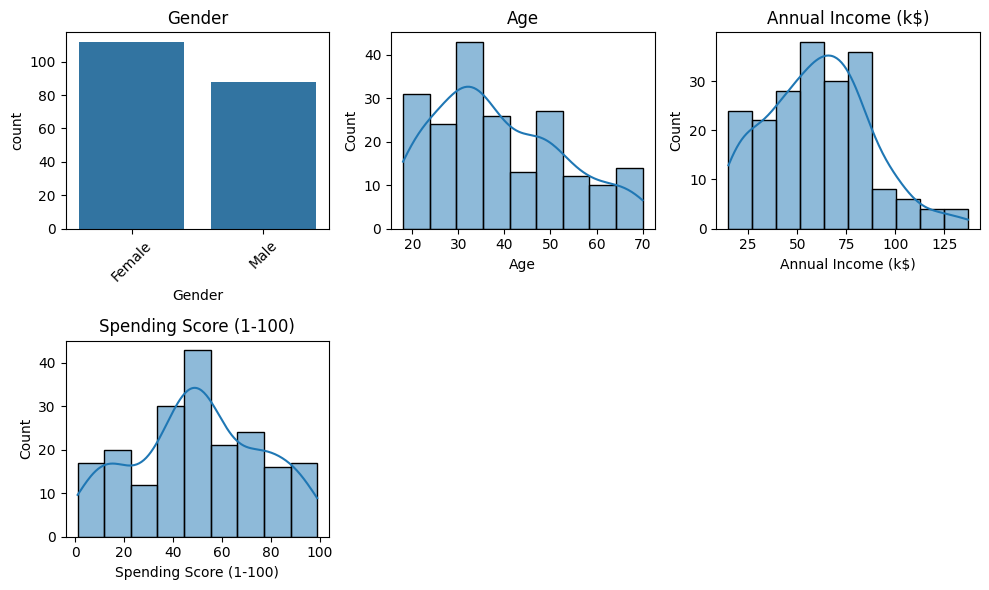

In [9]:
numeric_cols = data.select_dtypes(include=['number']).columns
categorical_cols = data.select_dtypes(exclude=['number']).columns

# Total number of plots
all_cols = list(data.columns)
n_cols = 3  # number of grid columns
n_rows = int(np.ceil(len(all_cols) / n_cols))

plt.figure(figsize=(10, n_rows * 3))

for i, col in enumerate(all_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    
    if col in numeric_cols:
        # Numeric -> histogram
        sns.histplot(data[col], kde=True)
    else:
        # Categorical -> count plot
        sns.countplot(x=data[col], order=data[col].value_counts().index)
        plt.xticks(rotation=45)
    
    plt.title(col)

plt.tight_layout()
plt.show()

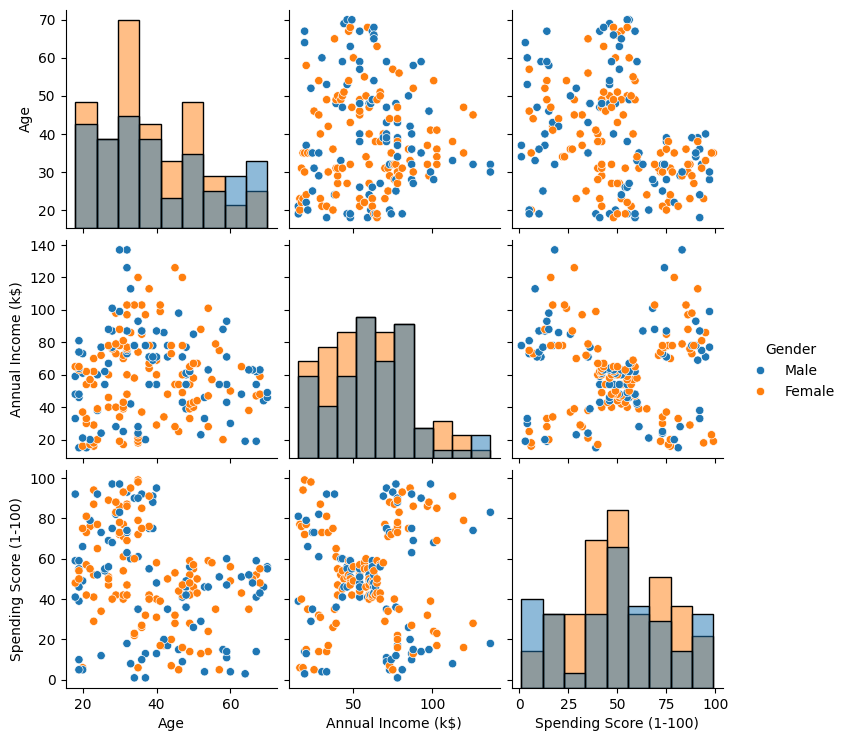

In [10]:
# Pairwise relationships (pairplot):
sns.pairplot(
    data,
    vars=["Age", "Annual Income (k$)", "Spending Score (1-100)"],
    hue="Gender",
    diag_kind="hist"
)

In [11]:
# There appears to be some visually noticeable clustering
# between annual income and spending score.

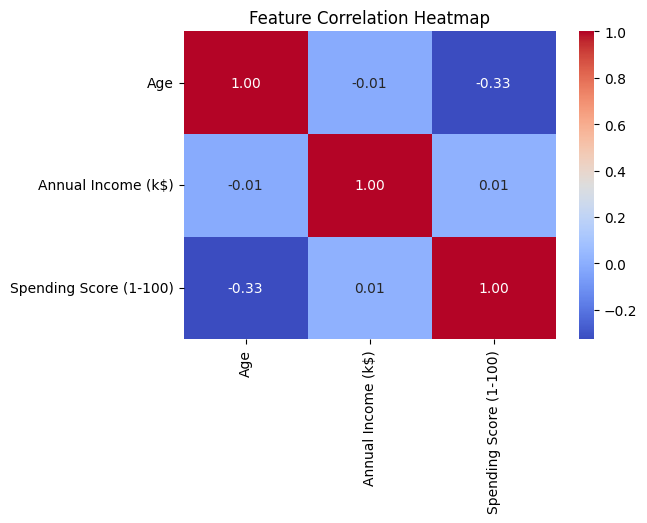

In [12]:
# Correlation heatmap:
plt.figure(figsize=(6, 4))
sns.heatmap(
    data[numeric_cols].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Feature Correlation Heatmap")
plt.show()

In [13]:
# Very slight negative correlation between spending score and age.
# othrwise the columns are uncorrelated

<Axes: xlabel='Gender', ylabel='Spending Score (1-100)'>

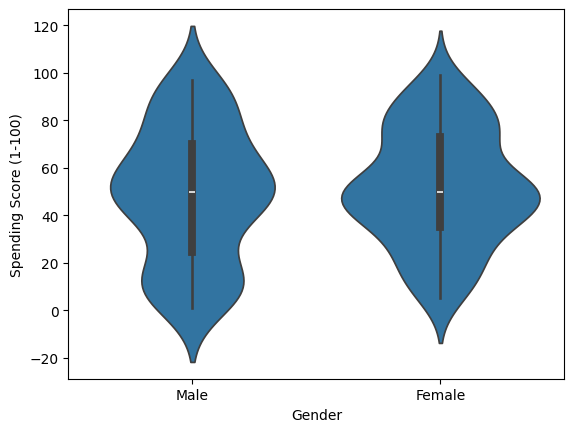

In [14]:
# How clustered is the data? (Violin plots):

sns.violinplot(
    data=data,
    x="Gender",
    y="Spending Score (1-100)"
)


In [15]:
# There appears to be some visually noticeable clustering.

<h4>Preparing Data for Modelling

<h5>Scaling

In [16]:
# Data scaling:
from sklearn.preprocessing import StandardScaler

# Hardly any outliers as seen in the boxplots. Will use standard scaler:
scaler = StandardScaler()
scaled = scaler.fit_transform(data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]])
scaled_df = pd.DataFrame(scaled, columns=["Age", "Annual Income (k$)", "Spending Score (1-100)"])
scaled_df

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


<h5>K-Means Clustering

In [17]:
from sklearn.cluster import KMeans

In [18]:
kmeans_5 = KMeans(n_clusters=5, random_state=13)
kmeans_5.fit(scaled_df)

KMeans(n_clusters=5, random_state=13)

In [19]:
data['Kmeans_Cluster_5'] = kmeans_5.labels_

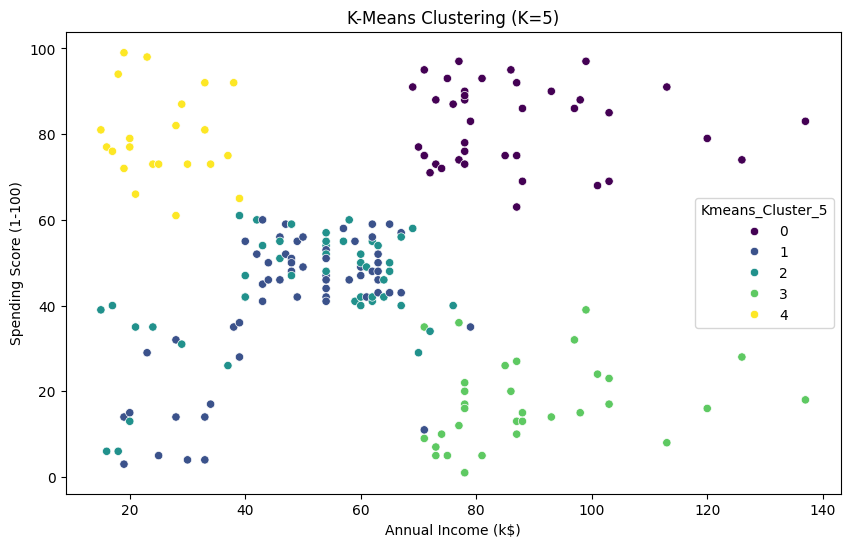

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Kmeans_Cluster_5', data=data, palette='viridis')
plt.title('K-Means Clustering (K=5)')
plt.show()

In [21]:
# Clusters 1 and 2 aren't particularly well resolved. May be better to do a
# K = 4 clustering?

In [22]:
kmeans_4 = KMeans(n_clusters=4, random_state=13)
kmeans_4.fit(scaled_df)
data['Kmeans_Cluster_4'] = kmeans_4.labels_

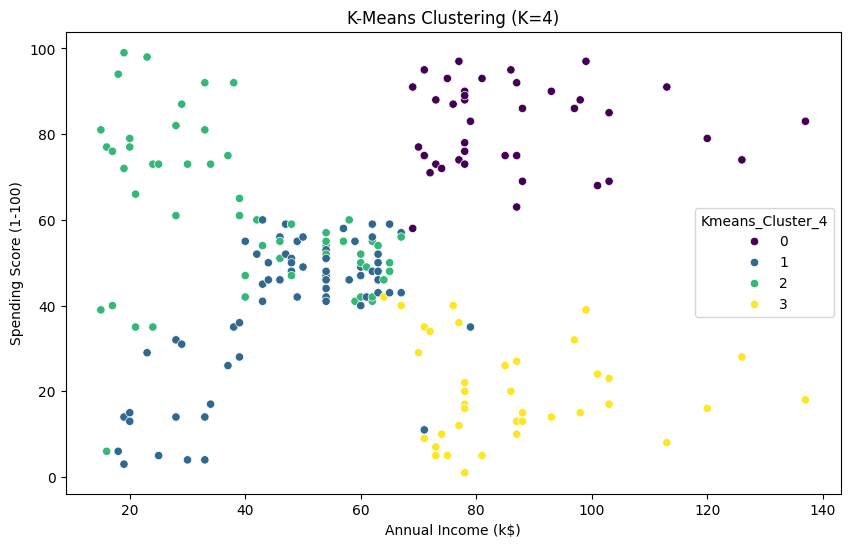

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Kmeans_Cluster_4', data=data, palette='viridis')
plt.title('K-Means Clustering (K=4)')
plt.show()

In [24]:
# Still seems to form overlapping clusters?
# More clusters?
kmeans_6 = KMeans(n_clusters=6, random_state=13)
kmeans_6.fit(scaled_df)
data['Kmeans_Cluster_6'] = kmeans_6.labels_

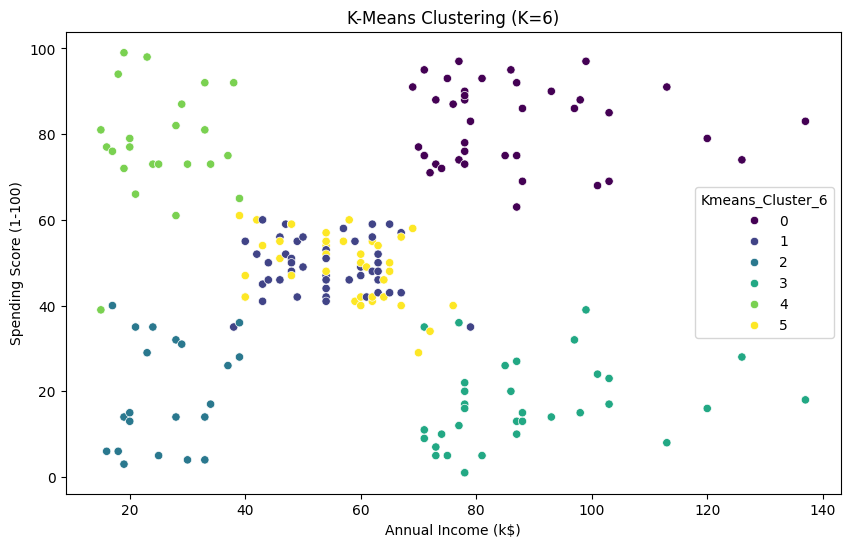

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Kmeans_Cluster_6', data=data, palette='viridis')
plt.title('K-Means Clustering (K=6)')
plt.show()

<h5>Hierarchial Clustering

In [26]:
from sklearn.cluster import AgglomerativeClustering

In [27]:
# K = 5
agglo_5 = AgglomerativeClustering(n_clusters=5)
data['Agglo_Cluster_5'] = agglo_5.fit_predict(scaled_df)

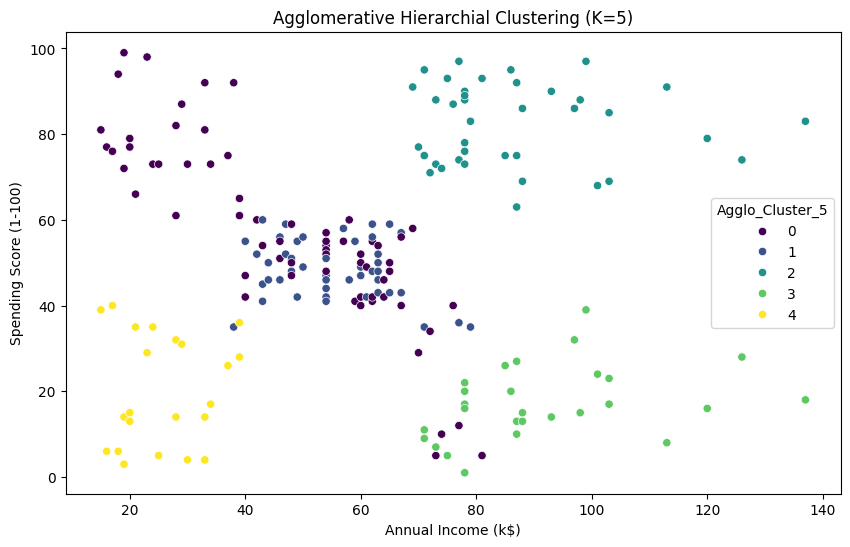

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Agglo_Cluster_5', data=data, palette='viridis')
plt.title('Agglomerative Hierarchial Clustering (K=5)')
plt.show()

In [29]:
# Clusters 0 and 1 aren't that well resolved.

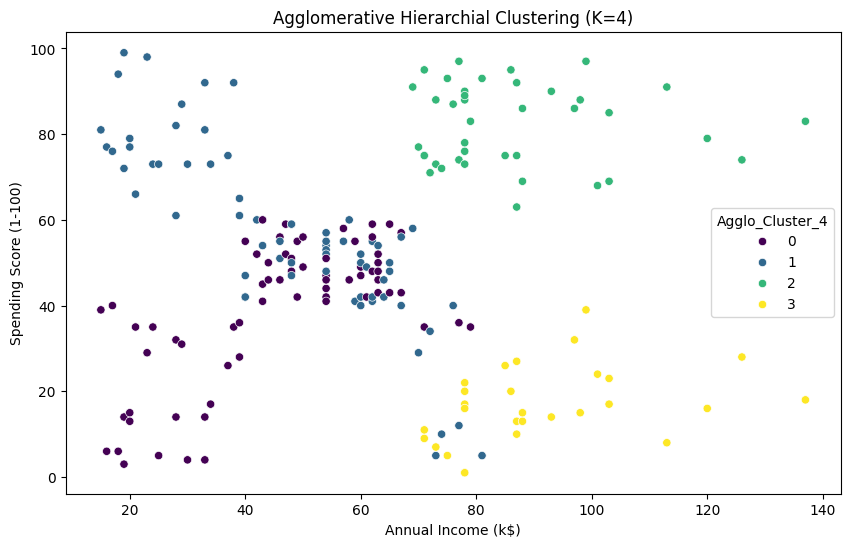

In [30]:
# K = 4
agglo_4 = AgglomerativeClustering(n_clusters=4)
data['Agglo_Cluster_4'] = agglo_4.fit_predict(scaled_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Agglo_Cluster_4', data=data, palette='viridis')
plt.title('Agglomerative Hierarchial Clustering (K=4)')
plt.show()

In [31]:
# Clusters 0 and 1 still overlap,  but have some unique characteristics

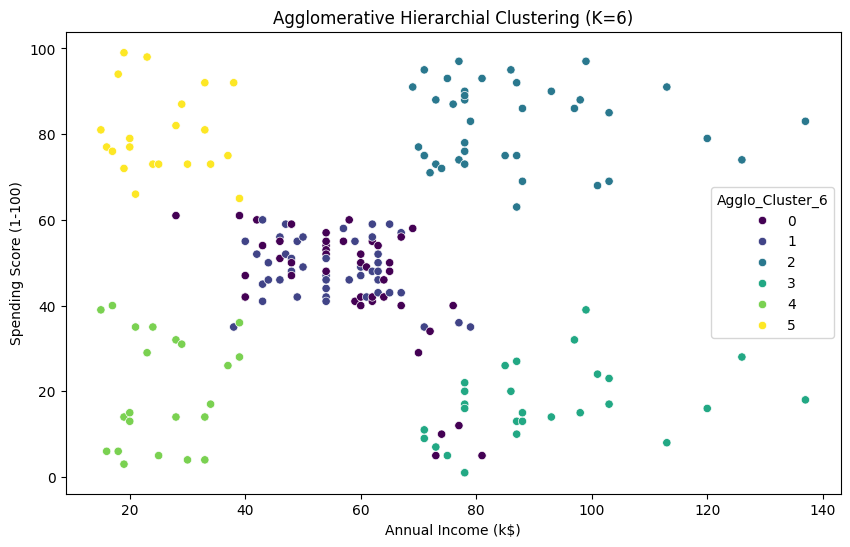

In [32]:
# K = 6
agglo_6 = AgglomerativeClustering(n_clusters=6)
data['Agglo_Cluster_6'] = agglo_6.fit_predict(scaled_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Agglo_Cluster_6', data=data, palette='viridis')
plt.title('Agglomerative Hierarchial Clustering (K=6)')
plt.show()

In [33]:
# Still have overlapping clusters.

<h5>Dendrogram

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage

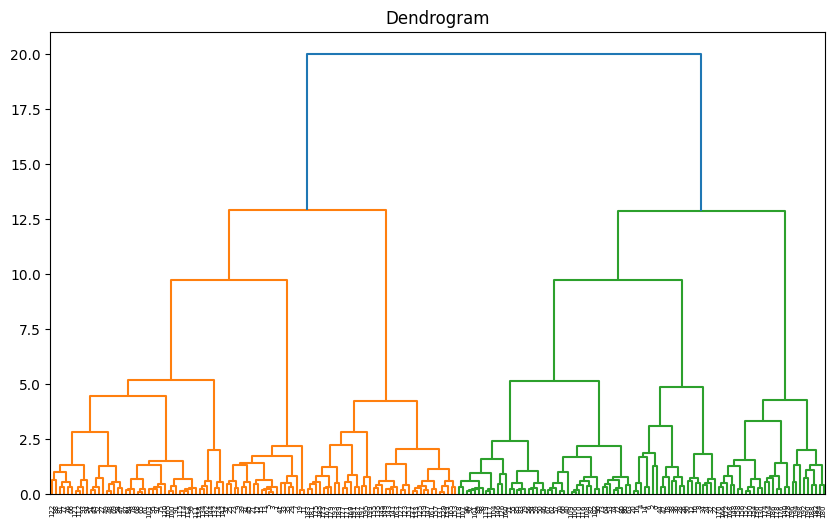

In [35]:
linked = linkage(scaled_df, method='ward') #Defines the distance between two clusters.
# Involves: 
# 1) Start with defining each data point as its own cluster. 
# 2) Repeatedly merges the two closest clusters.
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.show()

<h5>DBSCAN Clustering

In [36]:
from sklearn.cluster import DBSCAN

In [37]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
data['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_df)

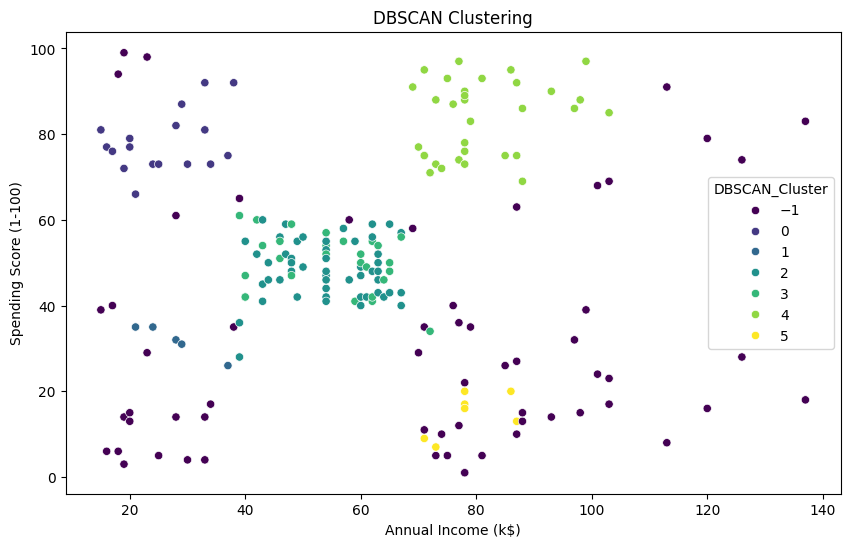

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='DBSCAN_Cluster', data=data, palette='viridis')
plt.title('DBSCAN Clustering')
plt.show()

<h5>Comparing the different models:

Silhouette: how close is each point to their own cluster relative to other clusters. 1 = good clustering, 0 = on cluster boundary, <0 = Likely misclustered.

Calinski–Harabasz Index: How separated clusters relative to their compactness. Higher values represent better clustering.

Davies–Bouldin Index: Measure of cluster overlap. Lower the better.
0 = perfect clustering.





In [39]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

/var/folders/bw/y81spjm11x78s7y1l9x977qc0000gn/T/ipykernel_20753/3370620286.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=sil_scores, palette='viridis')


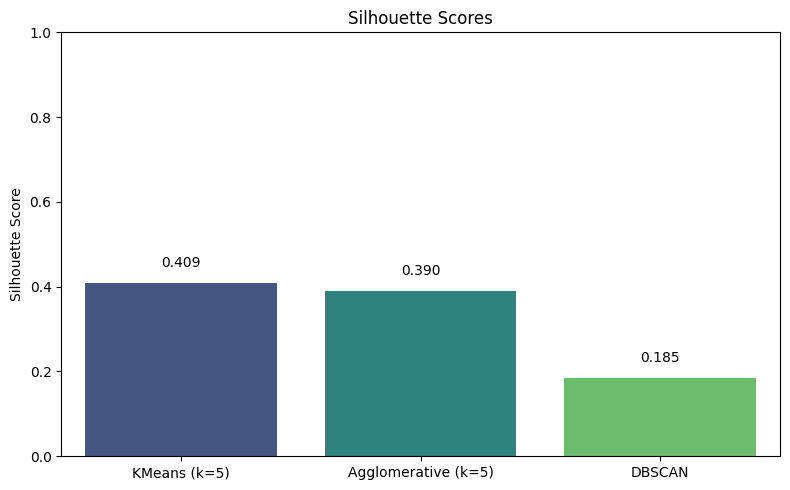

In [40]:
# Silhouette scores for KMeans (k=5), Agglomerative (k=5), and DBSCAN
km5_sil = silhouette_score(scaled_df, data['Kmeans_Cluster_5'])
agg5_sil = silhouette_score(scaled_df, data['Agglo_Cluster_5'])
dab_sil = silhouette_score(scaled_df, data['DBSCAN_Cluster'])

models = ['KMeans (k=5)', 'Agglomerative (k=5)', 'DBSCAN']
sil_scores = [km5_sil, agg5_sil, dab_sil]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=sil_scores, palette='viridis')
plt.title('Silhouette Scores')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)

for idx, val in enumerate(sil_scores):
    if not np.isnan(val):
        plt.text(idx, val + 0.03, f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [41]:
# Higher the better. Greater clustering for KMeans and agglo methods vs DBSCAN.

/var/folders/bw/y81spjm11x78s7y1l9x977qc0000gn/T/ipykernel_20753/4038242232.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=ch_scores, palette='viridis')


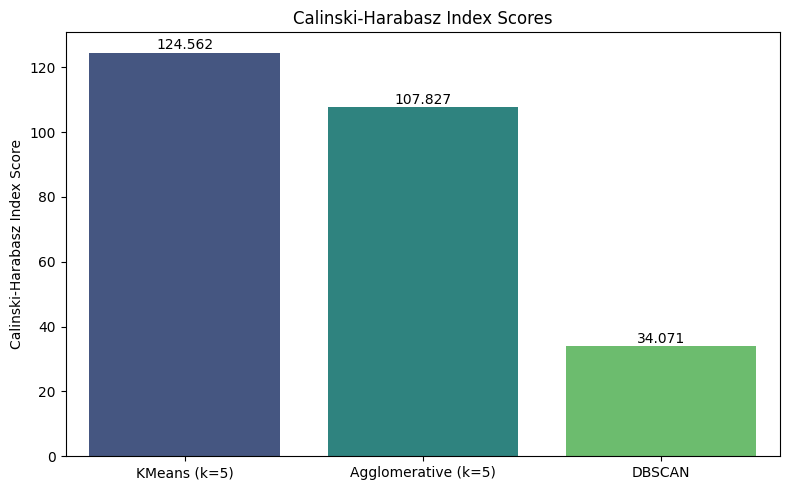

In [42]:
# Calinski-Harabasz Indexes for KMeans (k=5), Agglomerative (k=5), and DBSCAN
km5_ch = calinski_harabasz_score(scaled_df, data['Kmeans_Cluster_5'])
agg5_ch = calinski_harabasz_score(scaled_df, data['Agglo_Cluster_5'])
dab_ch = calinski_harabasz_score(scaled_df, data['DBSCAN_Cluster'])

models = ['KMeans (k=5)', 'Agglomerative (k=5)', 'DBSCAN']
ch_scores = [km5_ch, agg5_ch, dab_ch]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=ch_scores, palette='viridis')
plt.title('Calinski-Harabasz Index Scores')
plt.ylabel('Calinski-Harabasz Index Score')

for idx, val in enumerate(ch_scores):
    if not np.isnan(val):
        plt.text(idx, val + 0.03, f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [43]:
# Higher the better. Greater clustering for KMeans and agglo methods vs DBSCAN.

/var/folders/bw/y81spjm11x78s7y1l9x977qc0000gn/T/ipykernel_20753/915941700.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=db_scores, palette='viridis')


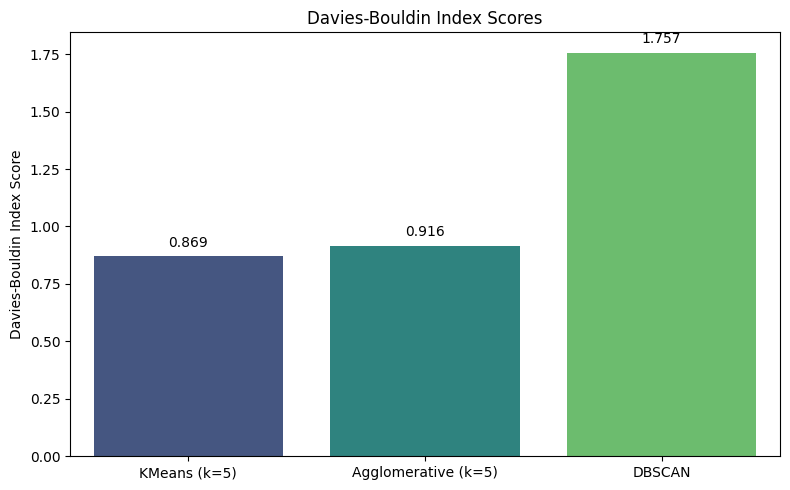

In [44]:
# Davies-Bouldin Indexes for KMeans (k=5), Agglomerative (k=5), and DBSCAN
km5_db = davies_bouldin_score(scaled_df, data['Kmeans_Cluster_5'])
agg5_db = davies_bouldin_score(scaled_df, data['Agglo_Cluster_5'])
dab_db = davies_bouldin_score(scaled_df, data['DBSCAN_Cluster'])

models = ['KMeans (k=5)', 'Agglomerative (k=5)', 'DBSCAN']
db_scores = [km5_db, agg5_db, dab_db]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=db_scores, palette='viridis')
plt.title('Davies-Bouldin Index Scores')
plt.ylabel('Davies-Bouldin Index Score')

for idx, val in enumerate(db_scores):
    if not np.isnan(val):
        plt.text(idx, val + 0.03, f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [45]:
# Lower the better. Greater clustering for KMeans and agglo methods vs DBSCAN.